In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from mpl_toolkits import mplot3d

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample
from patsy import dmatrices
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.discrete.discrete_model import Logit
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def diagnostic_plots(mod):
    sns.set_style('darkgrid')
    f, ax = plt.subplots(2,2, figsize=(12,10))
    
    smoothed = lowess(mod.resid, mod.fittedvalues)
    
    sns.scatterplot(x=mod.fittedvalues, y=mod.resid, ax=ax[0,0], alpha=0.5)
    ax[0,0].plot(smoothed[:,0], smoothed[:,1], color='red', alpha=0.8)
    ax[0,0].axhline(y=0, color='grey', ls='dashed', alpha=0.5)
    ax[0,0].set_xlabel('Fitted Values')
    ax[0,0].set_ylabel('Residuals')
    ax[0,0].set_title('Residuals vs Fitted')

    sm.qqplot(mod.resid, ax=ax[0,1], fit=True, line='45', alpha=0.5)
    ax[0,1].set_title('Normal Q-Q')
    
    student_residuals = mod.get_influence().resid_studentized_internal
    sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
    sqrt_student_residuals.index = mod.resid.index
    smoothed = lowess(sqrt_student_residuals,mod.fittedvalues)
    
    sns.scatterplot(x=mod.fittedvalues, y=sqrt_student_residuals, ax=ax[1,0], alpha=0.5)
    ax[1,0].plot(smoothed[:,0], smoothed[:,1], color='red', alpha=0.8)
    ax[1,0].set_xlabel('Fitted values')
    ax[1,0].set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
    ax[1,0].set_title('Scale-Location')
    
    smoothed = lowess(mod.get_influence().resid_studentized_internal, mod.get_influence().hat_matrix_diag)
    
    sns.scatterplot(x=mod.get_influence().hat_matrix_diag, y=mod.get_influence().resid_studentized_internal, ax=ax[1,1], alpha=0.5)
    ax[1,1].axhline(y=0, color='grey', linestyle='dashed', alpha=0.5)
    ax[1,1].plot(smoothed[:,0], smoothed[:,1], color='red', alpha=0.8)
    ax[1,1].set_xlabel('Leverage')
    ax[1,1].set_ylabel('Studentized Residuals')
    ax[1,1].set_title('Residuals vs Leverage')

## Chapter 5
### Lab
#### The Validation Set Approach

In [3]:
auto = pd.read_csv('Auto.csv')
auto.drop(auto.loc[auto['horsepower'] == '?'].index, inplace=True) 
auto['horsepower'] = pd.to_numeric(auto['horsepower'])
auto.drop('name', axis=1, inplace=True)

In [4]:
X = auto[['horsepower']]
y = auto['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=101)
lm = LinearRegression()
mod = lm.fit(X_train, y_train)
y_pred = mod.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}')

Mean Squared Error: 22.43


In [5]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
lm = LinearRegression()
mod = lm.fit(X_train_poly, y_train)
y_pred = mod.predict(poly.fit_transform(X_test))
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}')

Mean Squared Error: 17.25


In [6]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
lm = LinearRegression()
mod = lm.fit(X_train_poly, y_train)
y_pred = mod.predict(poly.fit_transform(X_test))
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}')

Mean Squared Error: 17.20


#### Leave-One-Out Cross-Validation

In [7]:
X = auto[['horsepower']]
y = auto['mpg']
lm = LinearRegression()
mod = lm.fit(X, y)
loo = LeaveOneOut()
scores = cross_val_score(mod, X, y, cv=loo, scoring='neg_mean_squared_error')

In [8]:
print(np.mean(np.absolute(scores))) # The LOOCV error for this model

24.231513517929226


In [9]:
for i in np.arange(1,6):
    X = auto[['horsepower']]
    y = auto['mpg']
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_poly = poly.fit_transform(X)
    lm = LinearRegression()
    mod = lm.fit(X_poly, y)
    loo = LeaveOneOut()
    scores = cross_val_score(mod, X_poly, y, cv=loo, scoring='neg_mean_squared_error')
    print(f'{np.mean(np.absolute(scores)):.2f}')

24.23
19.25
19.33
19.42
19.03


#### K-Fold Cross-Validation

In [10]:
for i in np.arange(1,11):
    X = auto[['horsepower']]
    y = auto['mpg']
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_poly = poly.fit_transform(X)
    lm = LinearRegression()
    mod = lm.fit(X_poly, y)
    cv = KFold(n_splits=10, shuffle=True, random_state=100)
    scores = cross_val_score(mod, X_poly, y, cv=cv, scoring='neg_mean_squared_error')
    print(f'{np.mean(np.absolute(scores)):.2f}')

24.27
19.29
19.44
19.54
19.07
18.93
19.09
19.31
19.29
19.05


#### The Bootstrap

In [11]:
port = pd.read_csv('Portfolio.csv')
port.head()

,X,Y
0,-0.895251,-0.234924
1,-1.562454,-0.885176
2,-0.417090,0.271888
3,1.044356,-0.734198
4,-0.315568,0.841983


In [12]:
def alpha(data):
    X = data['X']
    Y = data['Y']
    return ((np.var(Y) - np.cov(X,Y))/(np.var(X)+np.var(Y)-2*np.cov(X,Y)))[1,0]

In [13]:
boot = resample(port, replace=False, random_state=100)
alpha(boot)

0.5766511516104116

In [14]:
boot = resample(port, replace=True, random_state=100)
alpha(boot)

0.6092452073970155

In [15]:
def alpha2(data):
    X = data['X']
    Y = data['Y']
    print(f'Alpha: {((np.var(Y) - np.cov(X,Y))/(np.var(X)+np.var(Y)-2*np.cov(X,Y)))[1,0]:.2}')

In [16]:
boot = resample(port, replace=True, random_state=100, n_samples=1000)
alpha2(boot) 

Alpha: 0.53


In [17]:
def boot_fn(data):
    X = data[['horsepower']]
    y = data['mpg']
    lm = LinearRegression()
    mod = lm.fit(X,y)
    return np.round(mod.intercept_, 3), np.round(mod.coef_, 3)

In [18]:
boot_fn(auto)

(39.936, array([-0.158]))

In [19]:
boot_fn(resample(auto, replace=True, random_state=101))

(39.19, array([-0.152]))

In [20]:
boot_fn(resample(auto, replace=True, random_state=10))

(40.451, array([-0.161]))

In [21]:
sample = resample(auto, replace=True, random_state=101, n_samples=1000)
X = sample[['horsepower']]
y = sample['mpg']
mod = sm.OLS(y, sm.add_constant(X)).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     1525.
Date:                Tue, 02 Mar 2021   Prob (F-statistic):          3.45e-203
Time:                        01:00:41   Log-Likelihood:                -3015.1
No. Observations:                1000   AIC:                             6034.
Df Residuals:                     998   BIC:                             6044.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.5876      0.445     88.969      0.000      38.714      40.461
horsepower    -0.1553      0.004    -39.049      0.000      -0.163      -0.148
==============================================================================
Omnibus:                       24.488   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.771
Skew:                           0.392   Prob(JB):                     2.53e-06
Kurtosis:                       3.055   Cond. No.                         319.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
X = auto[['horsepower']]
y = auto['mpg']
mod = sm.OLS(y, sm.add_constant(X)).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           7.03e-81
Time:                        01:00:41   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
sample = resample(auto, replace=True, random_state=100, n_samples=1000)
X = sample[['horsepower']]
y = sample['mpg']
poly = PolynomialFeatures(2, include_bias=False)
X_poly = poly.fit_transform(X)
mod = sm.OLS(y, sm.add_constant(X_poly)).fit()
mod.summary()
# Bootstrap sample with 1000 samples

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     1243.
Date:                Tue, 02 Mar 2021   Prob (F-statistic):          1.63e-271
Time:                        01:00:41   Log-Likelihood:                -2869.9
No. Observations:                1000   AIC:                             5746.
Df Residuals:                     997   BIC:                             5760.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.2541      1.082     54.744      0.000      57.130      61.378
x1            -0.4996      0.019    -26.799      0.000      -0.536      -0.463
x2             0.0013    7.2e-05     18.540      0.000       0.001       0.001
==============================================================================
Omnibus:                       22.052   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.838
Skew:                          -0.075   Prob(JB):                     4.99e-10
Kurtosis:                       4.003   Cond. No.                     1.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
X = auto[['horsepower']]
y = auto['mpg']
poly = PolynomialFeatures(2, include_bias=False)
X_poly = poly.fit_transform(X)
mod = sm.OLS(y, sm.add_constant(X_poly)).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           5.40e-99
Time:                        01:00:41   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.9001      1.800     31.604      0.000      53.360      60.440
x1            -0.4662      0.031    -14.978      0.000      -0.527      -0.405
x2             0.0012      0.000     10.080      0.000       0.001       0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Applied Exercises
#### 5)
#### a) & b)

In [25]:
df = pd.read_csv('Default.csv')
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [27]:
df = pd.get_dummies(df, drop_first=True)

In [28]:
X = df[['balance', 'income']]
y = df['default_Yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=100)
log = LogisticRegression()
mod = log.fit(X_train, y_train)
y_pred = mod.predict(X_test)

In [29]:
def cfm(pred, y_true, class1='0', class2='1', error=False):
    ''' 
    Returns a Dataframe of the confusion matrix for a classification model given predictions and the true response values
    If error is passed as True, then it will also return the test error rate for the model 
    '''
    outside = ['Actual', 'Actual']
    inside = [class1, class2]
    outside2 = ['Prediction', 'Prediction']
    hier_index = list(zip(outside,inside))
    hier_col = list(zip(outside2, inside))
    hier_index = pd.MultiIndex.from_tuples(hier_index)
    hier_col = pd.MultiIndex.from_tuples(hier_col)
    if error == True:
        print(f' Test Error Rate: {np.mean(pred != y_true):.2%}')
    return pd.DataFrame(confusion_matrix(pred, y_true), index=hier_index, columns=hier_col)
    

In [30]:
cfm(y_pred, y_test, class1='No', class2='Yes', error=True)

 Test Error Rate: 2.76%


Prediction     
                   No  Yes
Actual No        4818  113
       Yes         25   44

#### c)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)
log = LogisticRegression()
mod = log.fit(X_train, y_train)
y_pred = mod.predict(X_test)
cfm(y_pred, y_test, 'No', 'Yes', error=True)

 Test Error Rate: 3.17%


Prediction     
                   No  Yes
Actual No        3873  124
       Yes          3    0

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
log = LogisticRegression()
mod = log.fit(X_train, y_train)
y_pred = mod.predict(X_test)
cfm(y_pred, y_test, 'No', 'Yes', error=True)

 Test Error Rate: 3.10%


Prediction    
                   No Yes
Actual No        2907  91
       Yes          2   0

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
log = LogisticRegression()
mod = log.fit(X_train, y_train)
y_pred = mod.predict(X_test)
cfm(y_pred, y_test, 'No', 'Yes', error=True)

 Test Error Rate: 2.60%


Prediction    
                   No Yes
Actual No        2414  55
       Yes         10  21

We see slight differences with the test error rate between the 4 different train/test splits which can be explained with the varying sizes of the test/validation set

#### d)

In [34]:
X = df[['balance', 'income', 'student_Yes']]
y = df['default_Yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=100)
log = LogisticRegression()
mod = log.fit(X_train, y_train)
y_pred = mod.predict(X_test)
cfm(y_pred, y_test, 'No', 'Yes', error=True)

 Test Error Rate: 3.36%


Prediction     
                   No  Yes
Actual No        4800  125
       Yes         43   32

The test error rate is slightly different which is not significant enough of a difference from the original model, so the student dummy variable does not change the error significantly

#### 6)
#### a)

In [35]:
X = df[['balance', 'income']]
y = df['default_Yes']
mod = Logit(y, sm.add_constant(X)).fit()
mod.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_Yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Tue, 02 Mar 2021   Pseudo R-squ.:                     inf
Time:                        01:00:41   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0.000     24.835      0.000       0.005       0.006
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

#### b)

In [36]:
def boot_fn(data):
    X = data[['balance','income']]
    y = data['default_Yes']
    log = LogisticRegression()
    mod = log.fit(X,y)
    return pd.DataFrame(mod.coef_, columns=['Balance', 'Income'], index=['Coefficients'])

In [37]:
boot_fn(df)

,Balance,Income
Coefficients,0.005647,0.000021


#### c)

In [38]:
sample = resample(df, replace=True, random_state=101, n_samples=100)
X = sample[['balance', 'income']]
y = sample['default_Yes']
mod = sm.Logit(y, sm.add_constant(X)).fit()
mod.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_Yes   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Tue, 02 Mar 2021   Pseudo R-squ.:                     inf
Time:                        01:00:41   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.0364      5.005     -2.805      0.005     -23.845      -4.228
balance        0.0073      0.003      2.890      0.004       0.002       0.012
income      2.948e-05    4.3e-05      0.686      0.493   -5.48e-05       0.000
==============================================================================

Possibly complete quasi-separation: A fraction 0.28 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Unfortunately, sklearn and statsmodels have no implentations to get the standard errors for the models beyond what shows in the summary

#### 7) 
#### a)

In [41]:
weekly = pd.read_csv('Weekly.csv')
weekly = pd.get_dummies(weekly, drop_first=True)

In [42]:
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Up
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,1


In [44]:
X = weekly[['Lag1', 'Lag2']]
y = weekly['Direction_Up']
log = LogisticRegression()
mod = log.fit(X, y)
y_pred = mod.predict(X)
cfm(y_pred, y, 'Down', 'Up', error=True)

 Test Error Rate: 44.54%


Prediction     
                  Down   Up
Actual Down         37   38
       Up          447  567

#### b)


In [47]:
X = weekly.iloc[1:][['Lag1', 'Lag2']]
y = weekly.iloc[1:]['Direction_Up']
log = LogisticRegression()
mod = log.fit(X, y)
y_pred = mod.predict(X)
cfm(y_pred, y, 'Down', 'Up', error=True)

 Test Error Rate: 44.30%


Prediction     
                  Down   Up
Actual Down         38   37
       Up          445  568

#### c)

In [104]:
y_pred_1st = mod.predict(weekly.iloc[0][['Lag1', 'Lag2']])
y_true = weekly.iloc[0]['Direction_Up']
print(y_pred_1st == y_true)

ValueError: Expected 2D array, got 1D array instead:
array=[0.816 1.572].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

#### d)

In [122]:
count = 0
for i in range(len(weekly)):
    X = weekly.drop(i)[['Lag1', 'Lag2']]
    y = weekly.drop(i)['Direction_Up']
    log = LogisticRegression()
    mod = log.fit(X, y)
    y_ipred = mod.predict(weekly.iloc[i][['Lag1', 'Lag2']].values.reshape(1,-1))
    y = weekly.iloc[i]['Direction_Up']
    if y_ipred != y:
        count += 1

#### e)

In [128]:
print(f'LOOCV error rate: {count/len(weekly):.2%}')

LOOCV error rate: 45.00%


The LOOCV error rate is shown to be 45% which means that it correctly predicts 55% of the data, which is not very good as its only 5% above chance

#### 8)
#### a)

In [146]:
np.random.seed(1)
y = np.random.randn(100)
x = np.random.randn(100)
y = x - 2*x**2 + np.random.randn(100)

$n = 100,  p = 2$

$Y = X - 2X^2 + e$

#### b)

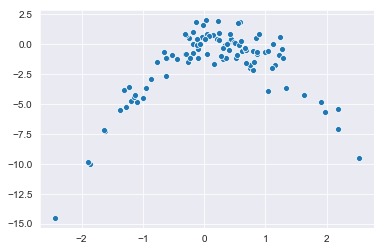

In [147]:
sns.set_style('darkgrid')
sns.scatterplot(x,y)

The relationship between x and y is non-linear 

#### c)

In [148]:
for i in np.arange(1,5):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_poly = poly.fit_transform(x.reshape(-1,1))
    lm = LinearRegression()
    mod = lm.fit(X_poly, y)
    loo = LeaveOneOut()
    scores = cross_val_score(mod, X_poly, y, cv=loo, scoring='neg_mean_squared_error')
    print(f'{np.mean(np.absolute(scores)):.2f}')

8.29
1.02
1.05
1.06


#### d)

In [151]:
np.random.seed(100)
y = np.random.randn(100)
x = np.random.randn(100)
y = x - 2*x**2 + np.random.randn(100)
for i in np.arange(1,5):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_poly = poly.fit_transform(x.reshape(-1,1))
    lm = LinearRegression()
    mod = lm.fit(X_poly, y)
    loo = LeaveOneOut()
    scores = cross_val_score(mod, X_poly, y, cv=loo, scoring='neg_mean_squared_error')
    print(f'{np.mean(np.absolute(scores)):.2f}')

10.07
1.19
1.24
1.29


The results differ between the two seeds since the actual values in x and y change completely, however, while the numbers do change the general idea of the errors is the same

#### e)
The model with the quadratic predictor had the lowest LOOCV which was expected since we could see from the scatter plot of x and y that their relationship looked quadratic in nature

In [152]:
for i in np.arange(1,5):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_poly = poly.fit_transform(x.reshape(-1,1))
    mod = sm.OLS(y, sm.add_constant(X_poly)).fit()
    print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     14.27
Date:                Tue, 02 Mar 2021   Prob (F-statistic):           0.000271
Time:                        15:03:48   Log-Likelihood:                -252.78
No. Observations:                 100   AIC:                             509.6
Df Residuals:                      98   BIC:                             514.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1594      0.307     -7.038      0.0

From these results we see that the predictors that correspond to degree 1 and degree 2 polynomials are statistically significant. This lines up with our LOOCV estimates of the error and also with our observation of the non-linear relationship between x and y

#### 9) 
#### a)

In [153]:
boston = datasets.load_boston()
bos = pd.DataFrame(boston.data, columns=boston.feature_names)
bos['MEDV'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [158]:
np.round(np.mean(bos['MEDV']),2)

22.53

#### b)

In [156]:
std = np.std(bos['MEDV'])
se = std/np.sqrt(len(bos['MEDV']))
np.round(se, 3)

0.408

#### c)

In [160]:
boot = resample(bos, replace=True, random_state=100)
boot_mean = np.mean(boot['MEDV'])
boot_std = np.std(boot['MEDV'])
boot_se = std/np.sqrt(len(boot['MEDV']))
np.round(se, 3)

0.415

In [166]:
print(f'[{boot_mean - 2*boot_se:.2f}, {boot_mean + 2*boot_se:.2f}]')

[21.94, 23.60]
